In this notebook, I'll be training a model on the natural image dataset available on Kaggle using transfer learning techniques to extract features from a pre-trained model to achieve high accuracy classification of this dataset

In [0]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn
from torchsummary import summary

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

After importing all the relevant libraries above, I'll now load the dataset from my Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#Visualising Data
classes = []
img_classes = []
n_image = []
height = []
width = []
dim = []


# Using folder names to identify classes
for folder in os.listdir('/content/drive/My Drive/data'):
    classes.append(folder)
    
    # Number of each image
    images = os.listdir('/content/drive/My Drive/data/'+folder)
    n_image.append(len(images))
      
    for i in images:
        img_classes.append(folder)
        img = np.array(Image.open('/content/drive/My Drive/data/'+folder+'/'+i))
        height.append(img.shape[0])
        width.append(img.shape[1])
    dim.append(img.shape[2])
    
df = pd.DataFrame({
    'classes': classes,
    'number': n_image,
    "dim": dim
})
print("Random heights:" + str(height[10]), str(height[23]))
print("Random Widths:" + str(width[10]), str(width[123]))
df

Random heights:115 110
Random Widths:297 302


,classes,dim,number
0,airplane,3,727
1,motorbike,3,788
2,dog,3,702
3,cat,3,885
4,flower,3,843
5,car,3,968
6,fruit,3,1000
7,person,3,986


In [0]:
image_df = pd.DataFrame({
    "classes": img_classes,
    "height": height,
    "width": width
})
img_df = image_df.groupby("classes").describe()
print(img_df)

           height                                                       \
            count        mean         std    min     25%    50%    75%   
classes                                                                  
airplane    727.0   93.155433   19.365537   54.0   81.00   92.0  104.0   
car         968.0  100.000000    0.000000  100.0  100.00  100.0  100.0   
cat         885.0  303.732203   95.744543   73.0  231.00  309.0  370.0   
dog         702.0  311.933048   99.654237   50.0  239.25  316.0  389.0   
flower      843.0  328.167260  189.871326   59.0  204.50  319.0  387.0   
fruit      1000.0  100.000000    0.000000  100.0  100.00  100.0  100.0   
motorbike   788.0  109.114213   12.083767   66.0  101.00  108.5  117.0   
person      986.0  255.981744    0.330622  250.0  256.00  256.0  256.0   

                    width                                                \
              max   count        mean         std    min     25%    50%   
classes                            

From Above, we can see the number of images each class contains, and that the height and width of images are not of a standard size. The only constant is the dimension, 3, representing that all are RGB colored images.

When using images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images and is therefore what the model expects. The images that are larger than this will be truncated while the smaller images will be interpolated. Data Augmentation and Resizing will be used later to modify the images

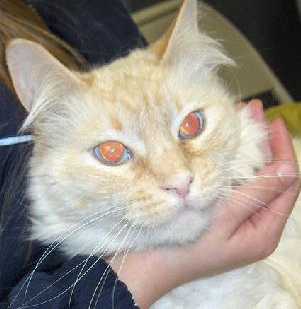

In [0]:
#Display random image
Image.open('/content/drive/My Drive/data/cat/cat_0007.jpg')

We'll define the transformations that will be done for the 3 different sets of data (training, validation, test - which will be split later as well). Only the training data will be augmented.

In [0]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.95, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Visualising and demonstrating how transformations will look like by writing a function below to plot examples of how images can be randomly transformed


In [0]:
def imshow_tensor(image, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

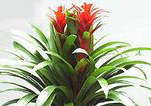

In [0]:
img = Image.open('/content/drive/My Drive/data/flower/flower_0124.jpg')
img

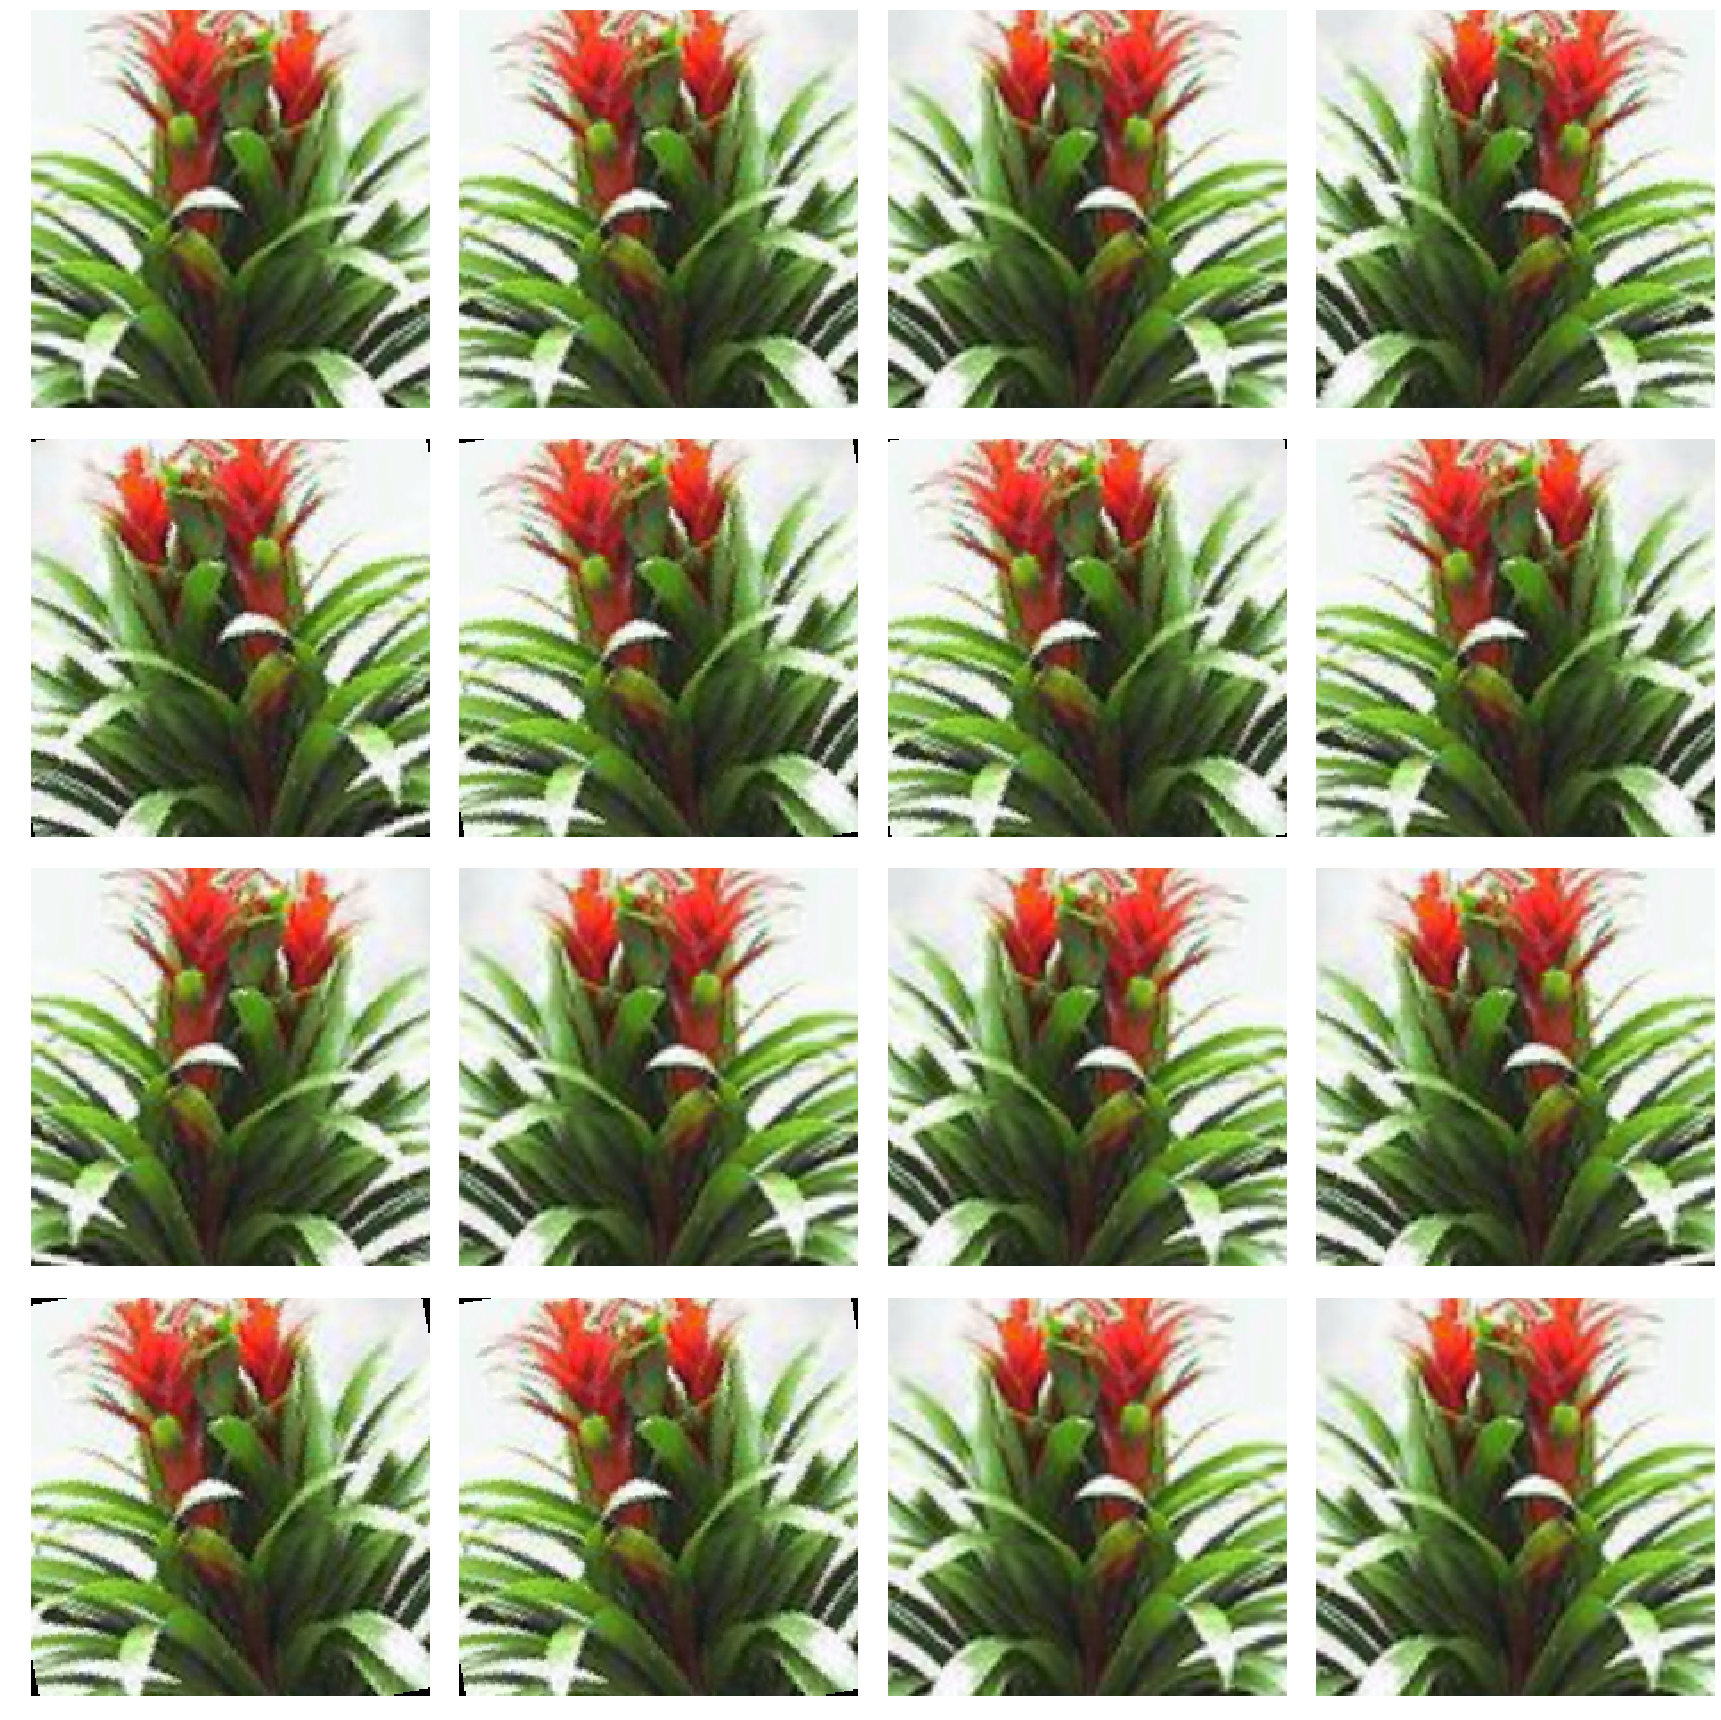

In [0]:
transform = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(transform(img), ax=ax)

plt.tight_layout()

Data is now split into training, validation and test sets and then loaded into the data loaders

In [0]:
batch_size = 128

all_data = datasets.ImageFolder(root='/content/drive/My Drive/data', transform=image_transforms['train'])
test_data = datasets.ImageFolder(root='/content/drive/My Drive/data', transform=image_transforms['test'])
train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)
train_data, _, _ = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
_, val_data, test_data = random_split(test_data, [train_data_len, valid_data_len, test_data_len])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [0]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([128, 3, 224, 224]) torch.Size([128])


Now that the data is prepared, We'll start defining the model used, which in this case is a pre-trained model

In [0]:
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

After freezing the pre-trained layers of the network (which will take extremely long if we were to retrain it due to the sheer amount of layers), we now have to define the classifier layer which we will train to suit our dataset and use case

In [0]:
n_classes = 8
n_inputs = model.classifier[6].in_features
# n_inputs will be 4096 for this case
# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, n_classes),
    nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=8, bias=True)
    (4): LogSoftmax()
  )
)

In [0]:
# Show the summary of our model and the training params
model.cuda()
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

The loss function and optimizer is defined below and the model will use GPU to train

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'airplane'),
 (1, 'car'),
 (2, 'cat'),
 (3, 'dog'),
 (4, 'flower'),
 (5, 'fruit'),
 (6, 'motorbike'),
 (7, 'person')]

In [0]:
def train(model,
         criterion,
         optimizer,
         train_loader,
         val_loader,
         save_location,
         early_stop=3,
         n_epochs=20,
         print_every=2):
   
  #Initializing some variables
  valid_loss_min = np.Inf
  stop_count = 0
  valid_max_acc = 0
  history = []
  model.epochs = 0
  
  #Loop starts here
  for epoch in range(n_epochs):
    
    train_loss = 0
    valid_loss = 0
    
    train_acc = 0
    valid_acc = 0
    
    model.train()
    ii = 0
    
    for data, label in train_loader:
      ii += 1
      data, label = data.cuda(), label.cuda()
      optimizer.zero_grad()
      output = model(data)
      
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      
      # Track train loss by multiplying average loss by number of examples in batch
      train_loss += loss.item() * data.size(0)
      
      # Calculate accuracy by finding max log probability
      _, pred = torch.max(output, dim=1) # first output gives the max value in the row(not what we want), second output gives index of the highest val
      correct_tensor = pred.eq(label.data.view_as(pred)) # using the index of the predicted outcome above, torch.eq() will check prediction index against label index to see if prediction is correct(returns 1 if correct, 0 if not)
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor)) #tensor must be float to calc average
      train_acc += accuracy.item() * data.size(0)
      if ii%15 == 0:
        print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')
      
    model.epochs += 1
    with torch.no_grad():
      model.eval()
      
      for data, label in val_loader:
        data, label = data.cuda(), label.cuda()
        
        output = model(data)
        loss = criterion(output, label)
        valid_loss += loss.item() * data.size(0)
        
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(label.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        valid_acc += accuracy.item() * data.size(0)
        
      train_loss = train_loss / len(train_loader.dataset)
      valid_loss = valid_loss / len(val_loader.dataset)
      
      train_acc = train_acc / len(train_loader.dataset)
      valid_acc = valid_acc / len(val_loader.dataset)
      
      history.append([train_loss, valid_loss, train_acc, valid_acc])
      
      if (epoch + 1) % print_every == 0:
        print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')
        
      if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), save_location)
        stop_count = 0
        valid_loss_min = valid_loss
        valid_best_acc = valid_acc
        best_epoch = epoch
        
      else:
        stop_count += 1
        
        # Below is the case where we handle the early stop case
        if stop_count >= early_stop:
          print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
          model.load_state_dict(torch.load(save_location))
          model.optimizer = optimizer
          history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
          return model, history
        
  model.optimizer = optimizer
  print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
  
  history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
  return model, history

In [0]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='/content/drive/My Drive/natural-images/natural_images.pt',
    early_stop=5,
    n_epochs=30,
    print_every=2)

Epoch: 0	36.36% complete.
Epoch: 0	70.45% complete.
Epoch: 1	36.36% complete.
Epoch: 1	70.45% complete.

Epoch: 1 	Training Loss: 0.0216 	Validation Loss: 0.0033
		Training Accuracy: 99.33%	 Validation Accuracy: 99.86%
Epoch: 2	36.36% complete.
Epoch: 2	70.45% complete.
Epoch: 3	36.36% complete.
Epoch: 3	70.45% complete.

Epoch: 3 	Training Loss: 0.0093 	Validation Loss: 0.0056
		Training Accuracy: 99.62%	 Validation Accuracy: 99.86%
Epoch: 4	36.36% complete.
Epoch: 4	70.45% complete.
Epoch: 5	36.36% complete.
Epoch: 5	70.45% complete.

Epoch: 5 	Training Loss: 0.0156 	Validation Loss: 0.0016
		Training Accuracy: 99.47%	 Validation Accuracy: 100.00%
Epoch: 6	36.36% complete.
Epoch: 6	70.45% complete.
Epoch: 7	36.36% complete.
Epoch: 7	70.45% complete.

Epoch: 7 	Training Loss: 0.0140 	Validation Loss: 0.0009
		Training Accuracy: 99.47%	 Validation Accuracy: 100.00%
Epoch: 8	36.36% complete.
Epoch: 8	70.45% complete.
Epoch: 9	36.36% complete.
Epoch: 9	70.45% complete.

Epoch: 9 	Trainin

In [0]:
history

,train_loss,valid_loss,train_acc,valid_acc
0,0.178849,0.007906,0.952346,0.995652
1,0.041099,0.003708,0.986954,1.000000
2,0.035776,0.002761,0.988223,1.000000
3,0.020597,0.001890,0.992934,1.000000
4,0.022962,0.005438,0.992571,0.998551
5,0.025342,0.001783,0.990940,1.000000
6,0.025426,0.001929,0.990397,1.000000
7,0.019277,0.001333,0.992571,1.000000
8,0.018179,0.000960,0.992934,1.000000
9,0.022514,0.002013,0.992934,0.998551


After training over a number of epochs, we can see that the model is able to pick up the features of the images very quickly and classify them accordingly, therefore the accuracy is also so high for the first few epochs. This is because the model was trained on ImageNet, which contained millions of data and over 1,000 classes, therefore the layers (which we froze) were able to pick out the distinguishing features of the images, making it straightforward for the classifier which we were training to predict accurately

In [0]:
def accuracy(model, test_loader, criterion):
  with torch.no_grad():
    model.eval()
    test_acc = 0
    for data, label in test_loader:
      data, label = data.cuda(), label.cuda()
      
      output = model(data)
      
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(label.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      test_acc += accuracy.item() * data.size(0)
      
    test_acc = test_acc / len(test_loader.dataset)
    return test_acc

I've defined the function for testing the model on the last set of data that we prepared earlier, and the model has never seen this set of data before.

In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/natural-images/natural_images.pt'))
test_acc = accuracy(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

The model has achieved an accuracy of 99.86% on the test dataset


To see which class the model made the mistake on, the function below picks it out individually

In [0]:
def evaluate(model, test_loader, criterion):
  
  classes = []
  acc_results = np.zeros(len(test_loader.dataset))
  i = 0

  model.eval()
  with torch.no_grad():
    for data, labels in test_loader:
      data, labels = data.cuda(), labels.cuda()
      output = model(data)
      
      for pred, true in zip(output, labels):
        _, pred = pred.unsqueeze(0).topk(1)
        correct = pred.eq(true.unsqueeze(0))
        acc_results[i] = correct.cpu()
        classes.append(model.idx_to_class[true.item()])
        i+=1
  
  results = pd.DataFrame({
      'class': classes,
      'results': acc_results    
  })
  results = results.groupby(classes).mean()

  return results


In [0]:
evaluate(model, test_loader, criterion)

,results
airplane,1.000000
car,1.000000
cat,0.988235
dog,1.000000
flower,1.000000
fruit,1.000000
motorbike,1.000000
person,1.000000
